In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0,'../../')

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from torchtrainer import img_util
from torchtrainer import transforms
import imgaug.augmenters as iaa
import re
from torch.utils.data import dataloader as torch_dataloader
from functools import partial
import torch

from torchtrainer.imagedataset import ImageDataset, ImageSegmentationDataset, ImagePatchDataset

In [39]:
# Create dataloaders
def name_to_label_map(img_filename):
    '''Maps image names to labels names in the DRIVE dataset
    
    Parameters
    ----------
    img_filename : string
        Filename of an image
        
    Returns
    -------
    label_filename : string
        Filename of the corresponding label image
    '''  
    
    m = re.match('(\d\d)_[training|test]', img_filename)
    index = m.group(1)
    label_filename = index + '_manual1.gif'
    
    return label_filename

def filename_filter(img_filename, test=False):
    '''Filter DRIVE images for getting only training or test images.
    
    Parameters
    ----------
    img_filename : string
        Filename of an image
    test : bool
        If True, the function checks if the image should be in the test set
    
    Returns
    -------
    bool
        If `test` is False, returns True if the image should be in the training set and
        False if it should be in the test set. Return values are reversed if `test` is True
    '''
    
    if test:
        return 'test' in img_filename
    else:
        return 'test' not in img_filename

root_dir = Path('../../../research/drive/data/DRIVE')
img_dir = root_dir/'images'
label_dir = root_dir/'labels'
mask_dir = root_dir/'mask'

# Create functions for using in the dataset creation
img_opener_partial = partial(img_util.pil_img_opener, channel=None)
label_opener_partial = partial(img_util.pil_img_opener, is_label=True)

# Image transformations
imgaug_seq = iaa.Sequential([
                            iaa.Resize({"height": 200, "width": 200}),
                            ])
transform_funcs = transforms.seq_pil_to_imgaug_to_tensor(imgaug_seq)

# Create ImageDataset instance
#dataset = ImageDataset(img_dir, name_to_label_map=name_to_label_map, filename_filter=filename_filter, 
#                       img_opener=img_opener_partial, transforms=transform_funcs)
dataset = ImageSegmentationDataset(img_dir, label_dir, name_to_label_map=name_to_label_map, filename_filter=filename_filter, 
                       img_opener=img_opener_partial, label_opener=label_opener_partial, transforms=transform_funcs)

dataset.check_dataset()

train_ds, valid_ds = dataset.split_train_val(0.2)

# We can grab all images as tensor
x_train,y_train = train_ds.as_tensor()
x_valid,y_valid = valid_ds.as_tensor()

# Or create a dataloader
train_dl = torch_dataloader.DataLoader(train_ds, batch_size=4, shuffle=True)
valid_dl = torch_dataloader.DataLoader(valid_ds, batch_size=4, shuffle=False)

All images read


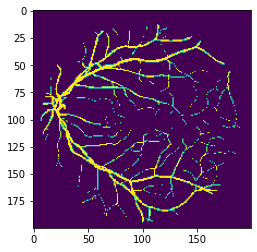

In [41]:
plt.imshow(dataset[0][1])

In [44]:
for wer in [1,2,3]:
    print(wer)

1
2
3


In [ ]:
def img_opener(img_file_path, is_label=False):
    
    if is_label: 
        img = torch.randint(0, 2, (50, 500, 500)) #np.random.randint(0, 2, (50, 500, 500))
    else:
        img = torch.randint(0, 256, (50, 500, 500)) #np.random.randint(0, 256, (50, 500, 500))
        
    return img

patch_size = (50, 100, 100)
stride = (50, 50, 50)


imgaug_seq = iaa.Sequential([
                            iaa.Resize({"height": 500, "width": 500}),
                            ])
img_transform_funcs = [] #transforms.seq_pil_to_imgaug_to_tensor(imgaug_seq)

# Patch transformations
imgaug_seq = iaa.Sequential([
                            iaa.Resize({"height": 120, "width": 120}),
                            ])
patch_transform_funcs = [partial(transforms.transf_to_tensor, is_3d=False), transforms.transf_normalize] 
                           #[transforms.transf_to_imgaug, transforms.translate_imagaug_seq(imgaug_seq), 
                           #transforms.transf_to_tensor]

# Create ImageDataset instance
dataset = ImagePatchDataset(patch_size, img_dir, label_dir, name_2_label_map=name_2_label_map, filename_filter=filename_filter,
                            img_opener=img_opener, label_opener=partial(img_opener, True), 
                            transforms=img_transform_funcs, patch_transforms=patch_transform_funcs, stride=stride)

#dataset.check_dataset()

train_ds, valid_ds = dataset.split_train_val(0.2)

# We can grab all images as tensor
x_train,y_train = train_ds.as_tensor()
x_valid,y_valid = valid_ds.as_tensor()

# Or create a dataloader
train_dl = torch_dataloader.DataLoader(train_ds, batch_size=4, shuffle=True)
valid_dl = torch_dataloader.DataLoader(valid_ds, batch_size=4, shuffle=False)